# REINFORCE Algorithm Implementation for CartPole

In this project, I will implement the REINFORCE algorithm to train an agent to balance a pole on a cart using the CartPole environment from OpenAI Gym. The objective is to understand the core concepts of the REINFORCE algorithm and gain hands-on experience in reinforcement learning.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import gymnasium as gym

In [77]:
class PolicyNetwork(nn.Module):
    """
    A neural network model for representing a policy in reinforcement learning.

    Args:
        layer_sizes (list[int]): The sizes of each layer in the network.
        activation (nn.Module): The activation function used for intermediate layers (default: nn.Tanh).
        output_activation (nn.Module): The activation function used for the output layer (default: nn.Identity).
    """
    def __init__(self, layer_sizes: list[int], activation=nn.Tanh, output_activation=nn.Identity):
        super().__init__()
        layers = []
        num_of_layers = len(layer_sizes)
        for i in range(num_of_layers - 1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            activation_function = activation if i < (num_of_layers - 2) else output_activation
            layers += [layer, activation_function()]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the policy network.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        logits = self.model(x)
        return Categorical(logits=logits)

    def update(self, optimizer, loss):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [78]:
class REINFORCE:
    """
    A reinforcement learning agent.

    Args:
        obs_space (int): The size of the observation space.
        hidden_sizes (list[int]): The sizes of the hidden layers in the policy network.
        n_act (int): The number of actions in the action space.
        learning_rate (float): The learning rate for the optimizer (default: 1e-3).
    """
    def __init__(self, obs_space, hidden_sizes, n_act, learning_rate=1e-4):
        self.policy_network = PolicyNetwork([obs_space, *hidden_sizes, n_act])
        self.optimizer = Adam(self.policy_network.parameters(), lr=learning_rate)

    def sample_action(self, obs):
        """
        Sample an action from the policy distribution given an observation.

        Args:
            obs (torch.Tensor): The observation tensor.

        Returns:
            int: The sampled action.
        """
        return self.policy_network(obs).sample().item()

    def compute_loss(self, observations, actions, weights):
        """
        Compute the policy gradient loss.

        Args:
            obs (torch.Tensor): The observation tensor.
            act (torch.Tensor): The action tensor.
            weights (torch.Tensor): The weights tensor. In this case, this is the reward of the current episode.

        Returns:
            torch.Tensor: The policy gradient loss.
        """
        logp = self.policy_network(observations).log_prob(actions)
        return -(logp * weights).mean()

    def store(self, filepath):
        """
        Store the agent's policy network parameters to a file.

        Args:
            filepath (str): The file path where the model parameters will be saved.
        """
        torch.save(self.policy_network.state_dict(), filepath)
        print(f'Model saved to {filepath}')

    def load(self, filepath):
        """
        Load the agent's policy network parameters from a file.

        Args:
            filepath (str): The file path where the model parameters are stored.
        """
        self.policy_network.load_state_dict(torch.load(filepath))
        self.policy_network.eval()
        print(f'Model loaded from {filepath}')

    def compute_discounted_return(self, rewards, gamma):
        discounted_returns = torch.zeros_like(rewards)
        discounted_return = 0
        for t in reversed(range(len(rewards))):
            discounted_return = rewards[t] + gamma * discounted_return
            discounted_returns[t] = discounted_return
        return discounted_returns


    def train(self, env, episodes=500):
        """
        Train the agent in the given environment.

        Args:
            env (Environment): The environment in which the agent will be trained.
            episodes (int): The number of episodes to run the training (default: 500).
            render (bool): Whether to render the environment during training (default: False).
        """
        returns, lengths = torch.zeros(episodes, dtype=torch.float32), torch.zeros(episodes, dtype=torch.float32)
        for episode in range(episodes):
            observations, actions, rewards = torch.zeros((500, env.observation_space.shape[0]), dtype=torch.float32), torch.zeros(500, dtype=torch.float32), torch.zeros(500, dtype=torch.float32)
            obs, info  = env.reset()
            obs = torch.tensor(obs, dtype=torch.float32)
            terminated = truncated = False
            t = 0
            while not terminated and not truncated:
                observations[t] = obs
                action = self.sample_action(obs)
                actions[t] = action
                obs, reward, terminated, truncated, info = env.step(action)
                obs = torch.tensor(obs, dtype=torch.float32)
                rewards[t] = reward
                t += 1
            observations, actions, rewards = observations[:t], actions[:t], rewards[:t]
            returns[episode] = rewards.sum()
            lengths[episode] = len(rewards)
            weights = self.compute_discounted_return(rewards, 0.99)
            loss  = self.compute_loss(observations, actions, weights)
            self.policy_network.update(self.optimizer, loss)
            if episode % 100 == 0:
                print(f"Episode: {episode}, Return: {rewards.sum()}")
        return returns

In [79]:
env = gym.make("CartPole-v1")
obs_space = env.observation_space.shape[0]
hidden_sizes = [64]
n_acts = env.action_space.n
agent = REINFORCE(obs_space=obs_space, hidden_sizes=hidden_sizes, n_act=n_acts)
episodes = 5000
returns = agent.train(env, episodes)
agent.store("model.pth")

Episode: 0, Return: 10.0
Episode: 100, Return: 22.0
Episode: 200, Return: 25.0
Episode: 300, Return: 9.0
Episode: 400, Return: 12.0
Episode: 500, Return: 23.0
Episode: 600, Return: 34.0
Episode: 700, Return: 11.0
Episode: 800, Return: 22.0
Episode: 900, Return: 17.0
Episode: 1000, Return: 16.0
Episode: 1100, Return: 26.0
Episode: 1200, Return: 29.0
Episode: 1300, Return: 26.0
Episode: 1400, Return: 36.0
Episode: 1500, Return: 29.0
Episode: 1600, Return: 13.0
Episode: 1700, Return: 97.0
Episode: 1800, Return: 46.0
Episode: 1900, Return: 21.0
Episode: 2000, Return: 48.0
Episode: 2100, Return: 35.0
Episode: 2200, Return: 61.0
Episode: 2300, Return: 25.0
Episode: 2400, Return: 15.0
Episode: 2500, Return: 15.0
Episode: 2600, Return: 93.0
Episode: 2700, Return: 81.0
Episode: 2800, Return: 58.0
Episode: 2900, Return: 144.0
Episode: 3000, Return: 50.0
Episode: 3100, Return: 127.0
Episode: 3200, Return: 24.0
Episode: 3300, Return: 97.0
Episode: 3400, Return: 187.0
Episode: 3500, Return: 122.0
E

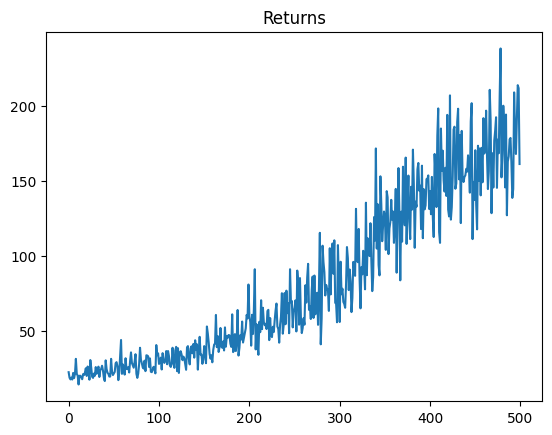

In [80]:
plt.title("Returns")
plt.plot(returns.reshape(-1, 10).mean(axis=1))